In [2]:
import sqlite3
import pickle
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from glob import glob
from tqdm import tqdm
from IPython.core.debugger import set_trace
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

In [3]:
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [4]:
mapping = pickle.load(open('datasets/user_anime_ratings_mapping.pkl', 'rb'))
mapping.keys()

dict_keys(['user2idx', 'anime2idx'])

In [5]:
num_users, num_anime = (108709, 6668)
batch_size = 1024

In [6]:
user_embeddings = pickle.load(open('user_embed_pytorch_nn_epoch4_embedding_fix_10.23-10.21.pkl', 'rb'))

In [7]:
anime_embeddings = pickle.load(open('anime_embed_pytorch_nn_epoch4_embedding_fix_10.23-10.21.pkl', 'rb'))

In [8]:
user_grouped_rating_files = [f for f in glob('datasets/user_grouped_anime_ratings.gz')]
user_grouped_rating_files.sort()

In [8]:
# class AnimeRatingsDataset(Dataset):
#     """Custom Dataset for loading entries from HDF5 databases"""

#     def __init__(self, sqlite_file, embedding_weights, transform=None):
#         self.db = sqlite3.connect(sqlite_file)
#         self.cursor = self.db.cursor()
#         self.embedding_weights = embedding_weights
#         self.length = self.cursor.execute('SELECT count(blob) from user_grouped;').fetchone()[0]

#     def extract_required_format(self, record):
#         num_records = len(record['anime_id'])
#         batch_anime_id = np.array(record['anime_id'], dtype=np.int16)
#         batch_anime_rating = np.array(record['my_score'], dtype=np.int16)
#         avg_rating = np.mean(batch_anime_rating)
#         avg_rating = 1 if avg_rating == 0 else avg_rating
#         num_anime_watched = len(batch_anime_id)
#         sum_rating = np.sum(batch_anime_rating)
#         sum_rating = 1 if sum_rating == 0 else sum_rating
#         record = np.sum(
#             self.embedding_weights[batch_anime_id] * batch_anime_rating.reshape(-1, 1), axis=0
#         ).astype(np.float32) / sum_rating
#         return record

#     def __getitem__(self, index):
#         if isinstance(index, torch.Tensor):
#             index = int(index)
#         row = self.cursor.execute('SELECT * from user_grouped where rowid=?', (index + 1, )).fetchone()
#         return self.extract_required_format(pickle.loads(row[1]))

#     def __len__(self):
#         return self.length

In [9]:
class AnimeRatingsDataset(Dataset):
    """Custom Dataset for loading entries from HDF5 databases"""

    def __init__(self, sqlite_file, anime_embeddings, user_embeddings, mapping, transform=None):
        self.df = pd.read_pickle(sqlite_file).reset_index()
        self.anime_embeddings = anime_embeddings.cpu().detach().numpy()
        self.user_embeddings = user_embeddings.cpu().detach().numpy()
        self.mapping = mapping
        self.length = self.df.shape[0]

    def extract_required_format(self, record):
        num_records = len(record['anime_id'])
        batch_anime_idx = np.array([self.mapping['anime2idx'][x] for x in record['anime_id']], dtype=np.int32)
        batch_anime_rating = np.array(record['my_score'], dtype=np.int16)
        num_anime_watched = len(batch_anime_idx)
        sum_rating = np.sum(batch_anime_rating)
        sum_rating = 1 if sum_rating == 0 else sum_rating
        sum_neg_rating = np.sum(10 - batch_anime_rating)
        sum_neg_rating = 1 if sum_neg_rating == 0 else sum_neg_rating
        anime_sum = np.sum(
            self.anime_embeddings[batch_anime_idx] * batch_anime_rating.reshape(-1, 1), axis=0
        ).astype(np.float32)
        anime_neg_sum = np.sum(
            self.anime_embeddings[batch_anime_idx] * (10 - batch_anime_rating.reshape(-1, 1)), axis=0
        ).astype(np.float32)
        result_sum_rating =  anime_sum / sum_rating
        result_mean_rating = anime_sum / num_anime_watched
        result_sum_neg_rating = anime_neg_sum / sum_neg_rating
        result = np.concatenate([
            result_sum_rating,
            result_sum_neg_rating,
            result_mean_rating
        ])
        return result, self.user_embeddings[self.mapping['user2idx'][record['user_id']]]

    def __getitem__(self, index):
        if isinstance(index, torch.Tensor):
            index = int(index)
        return self.extract_required_format(self.df.iloc[index])

    def __len__(self):
        return self.length

In [10]:
total_dataset = ConcatDataset([
    AnimeRatingsDataset(
        f,
        mapping=mapping,
        anime_embeddings=anime_embeddings,
        user_embeddings=user_embeddings
    ) for f in user_grouped_rating_files
])

train_size = int(len(total_dataset) * 0.8)
test_size = int(len(total_dataset) * 0.2)
total = sum([train_size, test_size])
diff = len(total_dataset) - total
train_dataset, test_dataset = random_split(total_dataset, (train_size + diff, test_size))

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

In [11]:
len(train_dataloader), len(test_dataloader)

(85, 22)

In [12]:
class Net(nn.Module):

    def __init__(self, anime_embedding_dim, bottleneck_dim=5, batch_size=batch_size):
        super(Net, self).__init__()

        self.anime_embedding_dim = anime_embedding_dim
        self.bottlenect_dim = 5
        self.batch_size = batch_size

        self.enc_fc1 = nn.Linear(150, 50)
        self.enc_fc2 = nn.Linear(50, 10)
        self.enc_fc3 = nn.Linear(10, bottleneck_dim)
        self.dec_fc1 = nn.Linear(bottleneck_dim, 10)
        self.dec_fc2 = nn.Linear(10, 25)
        self.dec_fc3 = nn.Linear(25, 50)


    def forward(self, x):
        # Autoencoder encoder stage
        enc_fc1_out = F.relu(self.enc_fc1(x))
        enc_fc2_out = F.relu(self.enc_fc2(enc_fc1_out))
        enc_fc3_out = F.relu(self.enc_fc3(enc_fc2_out))

        # Autoencoder decoder stage 
        dec_fc1_out = F.relu(self.dec_fc1(enc_fc3_out))
        dec_fc2_out = F.relu(self.dec_fc2(dec_fc1_out))
        dec_fc3_out = F.relu(self.dec_fc3(dec_fc2_out))
        return dec_fc3_out


model = Net(anime_embedding_dim=50)
model.to(device)
print(model)

Net(
  (enc_fc1): Linear(in_features=150, out_features=50, bias=True)
  (enc_fc2): Linear(in_features=50, out_features=10, bias=True)
  (enc_fc3): Linear(in_features=10, out_features=5, bias=True)
  (dec_fc1): Linear(in_features=5, out_features=10, bias=True)
  (dec_fc2): Linear(in_features=10, out_features=25, bias=True)
  (dec_fc3): Linear(in_features=25, out_features=50, bias=True)
)


In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
num_epochs = 3

In [15]:
def train(num_epochs, model, optimizer, criterion):
    train_loss = []
    validation_loss = []
    for epoch in range(num_epochs):
        print('Running epoch {}'.format(epoch + 1))
        train_epoch_loss = []
        validation_epoch_loss = []
        model = model.train()
        for param in model.parameters():
            param.requires_grad = True
        # Model Training
        for idx, (X, y) in enumerate(train_dataloader):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            X = X.to(device)
            y = y.to(device)
            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of anime indices.
            #record = torch.from_numpy(np.array([ 3, 23, 43, 53,  5,  4,  3, 67], dtype=np.int64)).to(device)

            prediction = model(X)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = criterion(prediction, y)
            loss.backward()
            optimizer.step()
            train_epoch_loss.append(float(loss))
            if idx % 40 == 0:
                print('Batch {} - Training loss: {}'.format(idx + 1, loss))
            del loss
            del prediction


        with torch.no_grad():
            model = model.eval()
            for param in model.parameters():
                param.requires_grad = False
            for idx, (X, y) in enumerate(test_dataloader):
                # Step 1. Remember that Pytorch accumulates gradients.
                # We need to clear them out before each instance
                model.zero_grad()

                X = X.to(device)
                y = y.to(device)
                # Step 2. Get our inputs ready for the network, that is, turn them into
                # Tensors of anime indices.
                #record = torch.from_numpy(np.array([ 3, 23, 43, 53,  5,  4,  3, 67], dtype=np.int64)).to(device)

                prediction = model(X)

                # Step 4. Compute the loss, gradients, and update the parameters by
                #  calling optimizer.step()
                loss = criterion(prediction, y)
                validation_epoch_loss.append(float(loss))
                if idx % 10 == 0:
                    print('Batch {} - Validation loss: {}'.format(idx + 1, loss))
                del loss
                del prediction
            model = model.train()

        train_loss.append(np.mean(train_epoch_loss))
        validation_loss.append(np.mean(validation_epoch_loss))
        print('Epoch {}: Mean training loss: {} Mean validation loss: {}'.format(epoch + 1, train_loss[-1], validation_loss[-1]))

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(num_epochs=10, optimizer=optimizer, model=model, criterion=criterion)

Running epoch 1
Batch 1 - Training loss: 1.8214648962020874
Batch 41 - Training loss: 1.6318243741989136
Batch 81 - Training loss: 1.664335012435913
Batch 1 - Validation loss: 1.6022791862487793
Batch 11 - Validation loss: 1.4943571090698242
Batch 21 - Validation loss: 1.5524723529815674
Epoch 1: Mean training loss: 1.684439821804271 Mean validation loss: 1.5875695943832397
Running epoch 2
Batch 1 - Training loss: 1.606106162071228
Batch 41 - Training loss: 1.5621882677078247
Batch 81 - Training loss: 1.5743423700332642
Batch 1 - Validation loss: 1.5625861883163452
Batch 11 - Validation loss: 1.5122735500335693
Batch 21 - Validation loss: 1.4800862073898315
Epoch 2: Mean training loss: 1.563889503479004 Mean validation loss: 1.5121643597429448
Running epoch 3
Batch 1 - Training loss: 1.5317864418029785
Batch 41 - Training loss: 1.5011523962020874
Batch 81 - Training loss: 1.4185843467712402
Batch 1 - Validation loss: 1.4704281091690063
Batch 11 - Validation loss: 1.394219994544983
Batc

In [17]:
torch.save(model.state_dict, 'autoencoder_10epochs.pth')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train(num_epochs=10, optimizer=optimizer, model=model, criterion=criterion)

Running epoch 1
Batch 1 - Training loss: 1.3883973360061646
Batch 41 - Training loss: 1.4170658588409424
Batch 81 - Training loss: 1.4082369804382324
Batch 1 - Validation loss: 1.419114112854004
Batch 11 - Validation loss: 1.4962347745895386
Batch 21 - Validation loss: 1.353446364402771
Epoch 1: Mean training loss: 1.4242379384882309 Mean validation loss: 1.410010121085427
Running epoch 2
Batch 1 - Training loss: 1.3586822748184204
Batch 41 - Training loss: 1.4589440822601318
Batch 81 - Training loss: 1.4188942909240723
Batch 1 - Validation loss: 1.4276455640792847
Batch 11 - Validation loss: 1.4059468507766724
Batch 21 - Validation loss: 1.4438374042510986
Epoch 2: Mean training loss: 1.4239942704930024 Mean validation loss: 1.4137762784957886
Running epoch 3
Batch 1 - Training loss: 1.434733271598816
Batch 41 - Training loss: 1.4547758102416992
Batch 81 - Training loss: 1.4284988641738892
Batch 1 - Validation loss: 1.3877053260803223
Batch 11 - Validation loss: 1.472208857536316
Batc

In [20]:
torch.save(model.state_dict, 'autoencoder_20epochs.pth')

In [15]:
mapping['idx2user'] = {v: k for k, v in mapping['user2idx'].items()}
mapping['idx2anime'] = {v: k for k, v in mapping['anime2idx'].items()}

In [16]:
model.load_state_dict(torch.load('autoencoder_20epochs.pth')())

In [17]:
topn = 50
users_idx = range(topn)
top_user_id = [mapping['idx2user'][u] for u in users_idx]
top_users = user_embeddings[users_idx]
dataset = total_dataset.datasets[0]
top_records = dataset.df.set_index('user_id').loc[top_user_id]
top_records
prediction_model = model.eval()
for param in prediction_model.parameters():
    param.requires_grad = False

In [35]:
computed_records = [dataset.extract_required_format(record) for _, record in top_records.reset_index().iterrows()]
computer_records = [(torch.from_numpy(x), torch.from_numpy(y)) for x, y in computed_records]
X = torch.tensor([z[0] for z in computed_records]).to(device)
y = torch.tensor([z[1] for z in computed_records]).to(device)

In [38]:
predicted_embeddings = prediction_model(X)

In [45]:
top_users.shape, predicted_embeddings.shape

(torch.Size([50, 50]), torch.Size([50, 50]))

In [48]:
from sklearn.decomposition.pca import PCA

actual = top_users.cpu().detach().numpy()
predicted = predicted_embeddings.cpu().detach().numpy()
pca = PCA(n_components=2)
pca = pca.fit(actual)
condensed_actual = pca.transform(actual)
condensed_predicted = pca.transform(predicted)

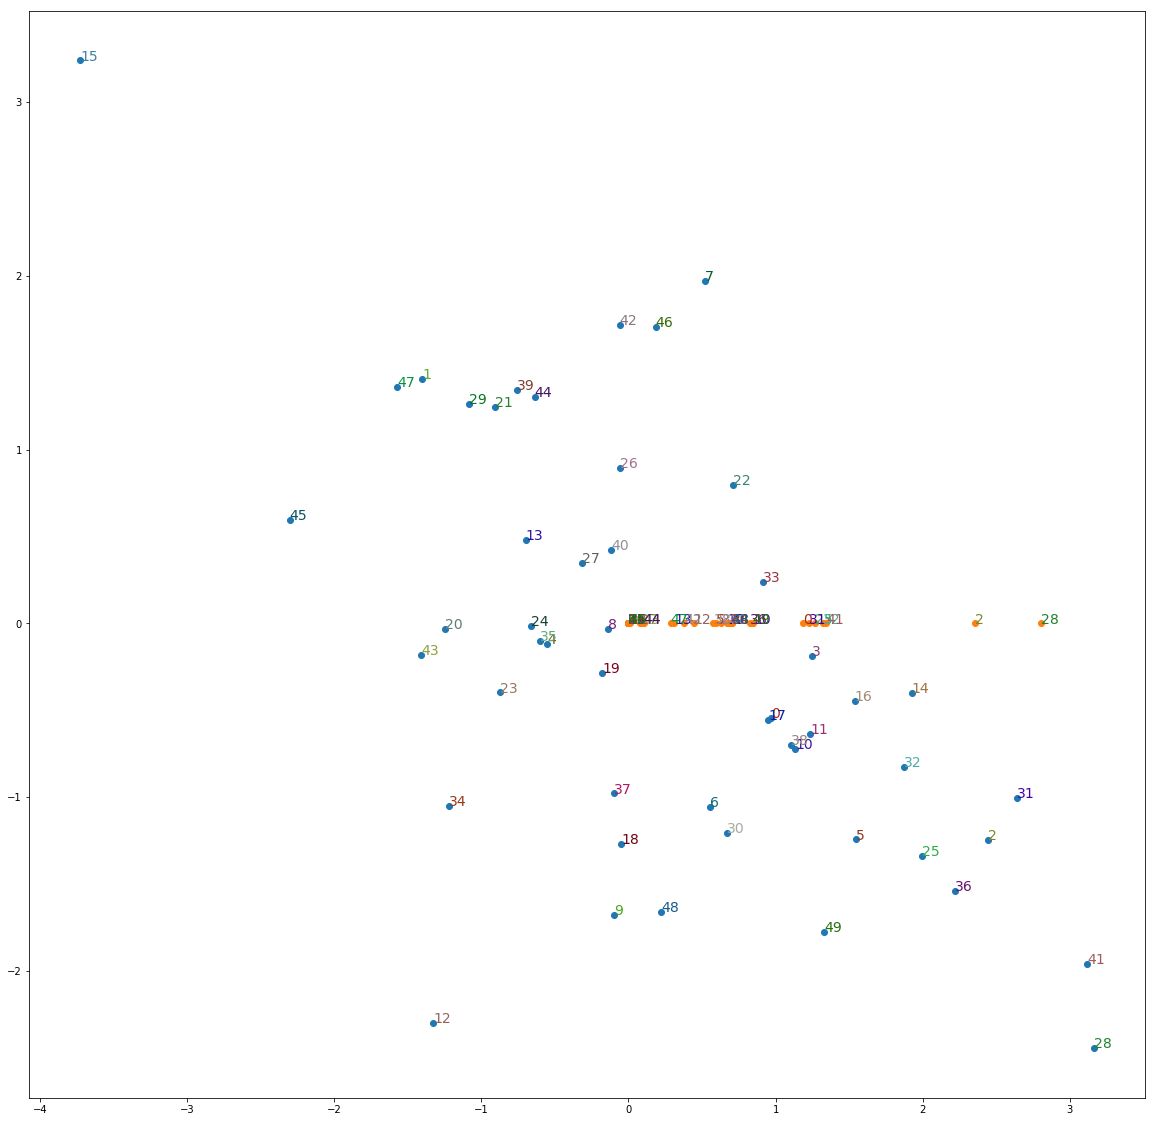

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline 

def generate_plot_embeddings(actual, predicted, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    plt.scatter(actual[:, 0], actual[:, 1])
    plt.scatter(predicted[:, 0], predicted[:, 1])
    for idx, (actual_row, predicted_row) in enumerate(zip(actual, predicted)):
        color = np.random.rand(3)*0.7
        plt.text(actual_row[0],
                 actual_row[1],
                 idx, color=color, fontsize=14)
        plt.text(predicted_row[0],
                 predicted_row[1],
                 idx, color=color, fontsize=14)
    plt.show()
generate_plot_embeddings(actual, predicted)